<a href="https://colab.research.google.com/github/dataqueenpend/-Assignments_fsDS_OneNeuron/blob/main/Hands_on_ML_Regression_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code in this notebook belongs to the creators of Hands on ML book. [Source]('https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb')
It is a part of exercise in the book.

#For the environment globally

In [40]:
import os
import tarfile
import urllib.request
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

#For the plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#There is also a code in the source for saving the plots to dir (maybe later)


#Part of code responsible for downloading the data in tgz file (compressed csv). 

##Function that fetches latest data automatically

In [41]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [42]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [43]:
fetch_housing_data()

##Loading data with pandas 

In [44]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

#First look on the data

In [45]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [46]:
housing.shape

(20640, 10)

In [47]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* Seems like total_bedrooms have some missing values - 20433 non-null/20640 possible.

* ocean_proximity is an object type data, which in this case means categorical feature
  > let's take a look on the unique categories 

In [48]:
housing['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [49]:
housing['ocean_proximity'].value_counts(ascending=False)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Taking a look at some summary statics of the numerical features. 

In [50]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Checking out numerical values with hist() function

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03494a5990>,
      dtype=object)

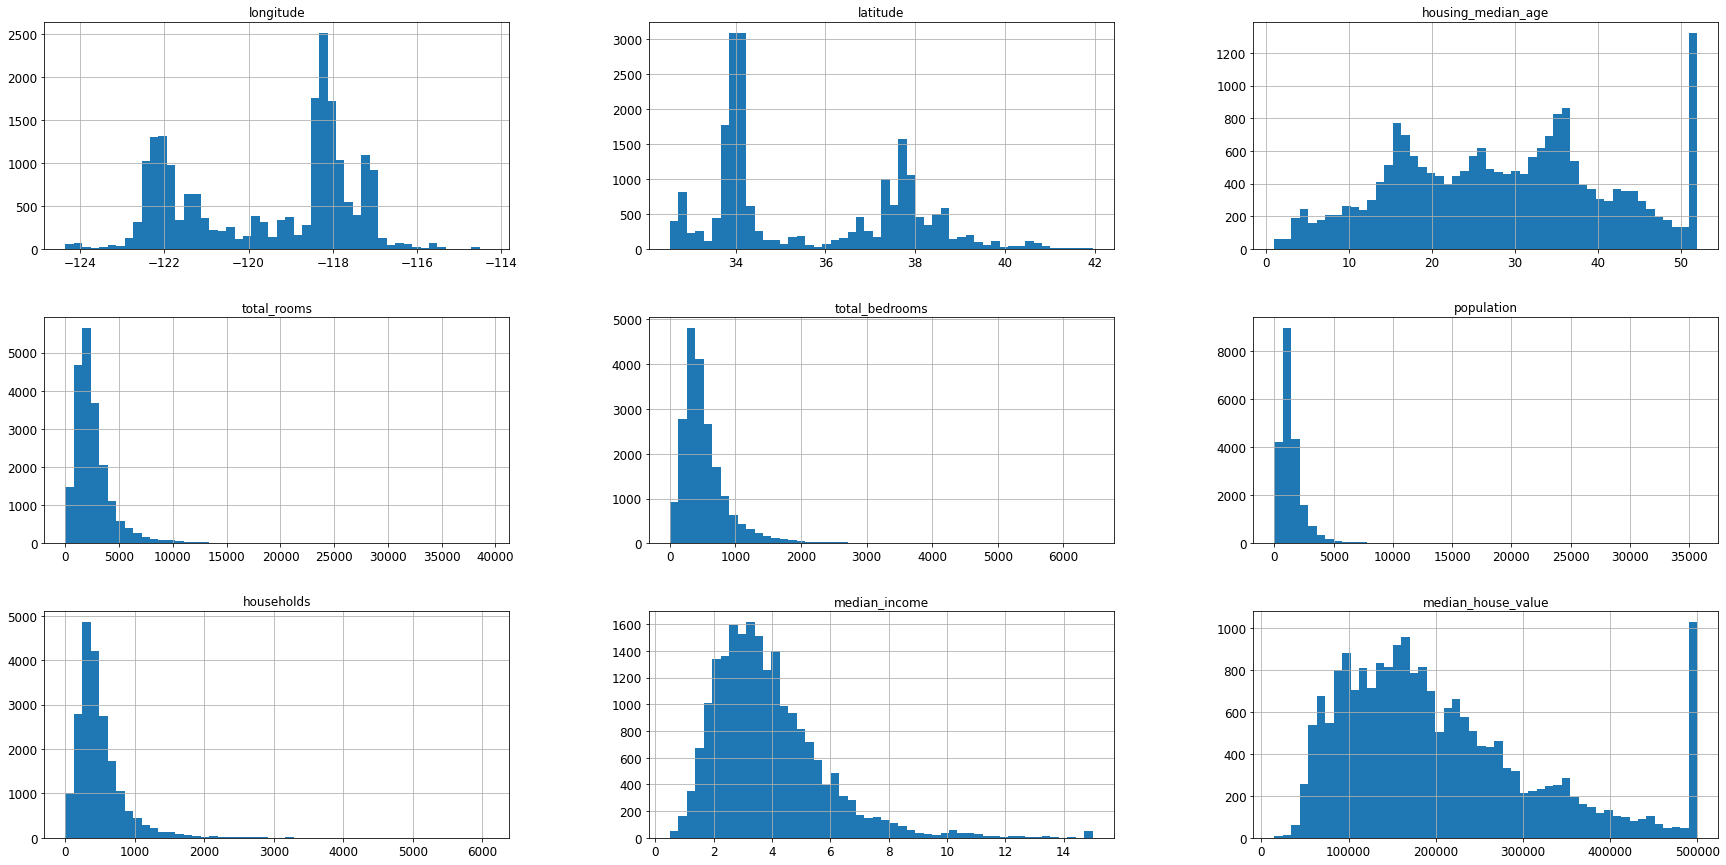

In [51]:
housing.hist(bins=50, figsize=(30,15))


* median_income values are not measured in USD, but it is scaled and capped at 15 001 and 0.4999.  The numbers are representing roughly 10 000 usd. So 2 is 20 000. 
* another capped valaues are housing_median_age and median_house_value - the median_house_value which is our target is ending at 500000 which can be a problem. ML can learn, that there are no houses above this value. This can be deal with with one of the two way: 
  * colects proper labels for the district which were capped
  * removes those districts from the dataset - it will prevent the poor evaluation of prediction, which should be predicted beyond 50 0000. 

* features ared scaled different - it is a case for later (feature scaling)
* some of the features have right tails, which can be troublesome to work with with some ml algorithms - this also needs to be addressed later. 

##Splitting the data

It is a good practice to set random_seed, that function will select always the same set of data for training and test, everytime it is called. Not doing so can cause in time, that model will see in time all the data from both training and test set. 

But if the next update will come up, it could brake the data. The solution for this is setting up instance's identifier, that would decide if the will go in the test or training set. 

In [52]:
#Split function
def split_function(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [53]:
train_set, test_set = split_function(housing, 0.2)

In [54]:
len(train_set)

16512

In [55]:
len(test_set)

4128

In [56]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier) & 0xffffffff < test_ratio * 2**32)

In [57]:
def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [58]:
housing_with_id = housing.reset_index()

In [59]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [60]:
#train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

The same thing as the function split_train_test is doing the dunction from sckit-learn library - train_test_split. And it's also have a couple of additional features. Like for example random_state. 
> Also by using train_test_split function from sklearn we can split multiple datasets on the same indices. (number of rows must be identical?) This feature can be use if we have seperate dataframe for labels. 



##Splitting with sklearn

In [61]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

###Creating income category

In [62]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0.,1.5,3.0,4.5,6.0, np.inf], labels=[1,2,3,4,5])

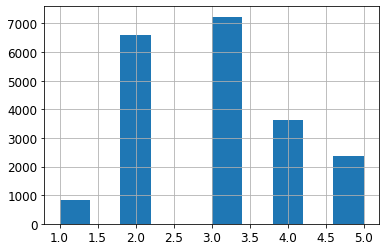

In [63]:
housing['income_cat'].hist()

###StratifiedShuffleSplit

In order to receive representive set of data we will use stratified sampling based on the income category. 
> It is important to have representitive set of data due to statistics reason -> check out more about stratified data in the Hand on ML (54,55 | Chapter 2: End-to-End Machine Learning Project) book or just on the internet. 

To create more representitive dataset we'll use sklearn StratiffiedShuffleSplit class.

In [64]:
from sklearn.model_selection import StratifiedShuffleSplit

In [65]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [66]:
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [67]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

We can measure the income category proportion in random set, full set and stratified set. 

In [68]:
def income_proportions(data):
  return data['income_cat'].value_counts()/len(data)

In [69]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [70]:
comparison = pd.DataFrame({
    'Full dataset': income_proportions(housing),
    'Stratified': income_proportions(strat_test_set),
    'Random': income_proportions(test_set)
}).sort_index()

In [71]:
comparison['Random % error'] = 100 * comparison['Random']/ comparison['Full dataset'] - 100
comparison['Stratified % error'] = 100 * comparison['Stratified']/ comparison['Full dataset'] - 100

In [72]:
comparison

,Full dataset,Stratified,Random,Random % error,Stratified % error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


Removing income category. 

In [73]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

##EDA

Setting out the test set aside, we'll perform our exploration on train data only. If we'd be dealing with a large dataset, we could sample an exploration set. 

> We'll be doing EDA on the copy of the training set, to not mess up the original. 

In [74]:
housing = strat_train_set.copy()

###Geogrphical data visualization

We can visualize the geographical data (longitude, latitude)

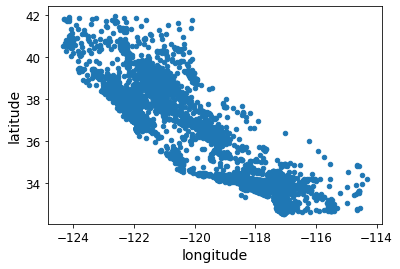

In [75]:
housing.plot(x='longitude', y = 'latitude', kind='scatter')

Check out that!
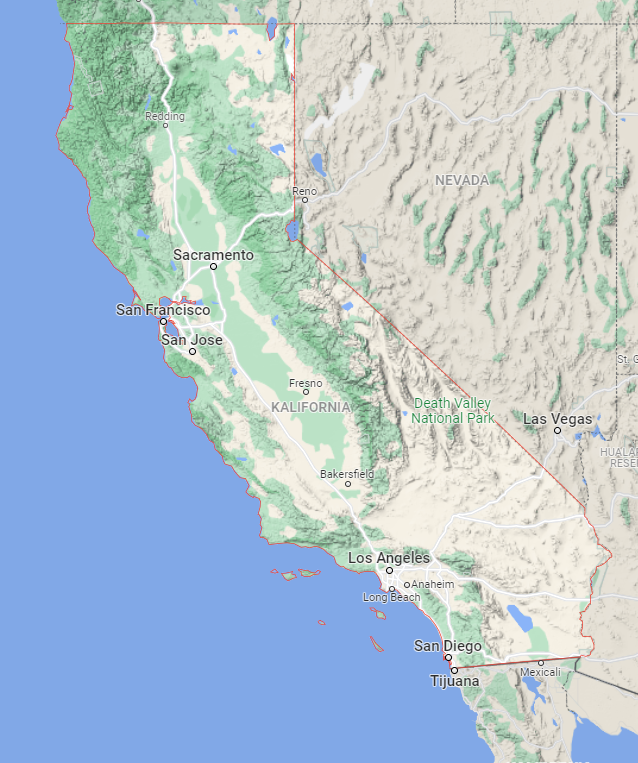
It is California

To see better where, the density of those data points is, we'll set up alpha parameter.

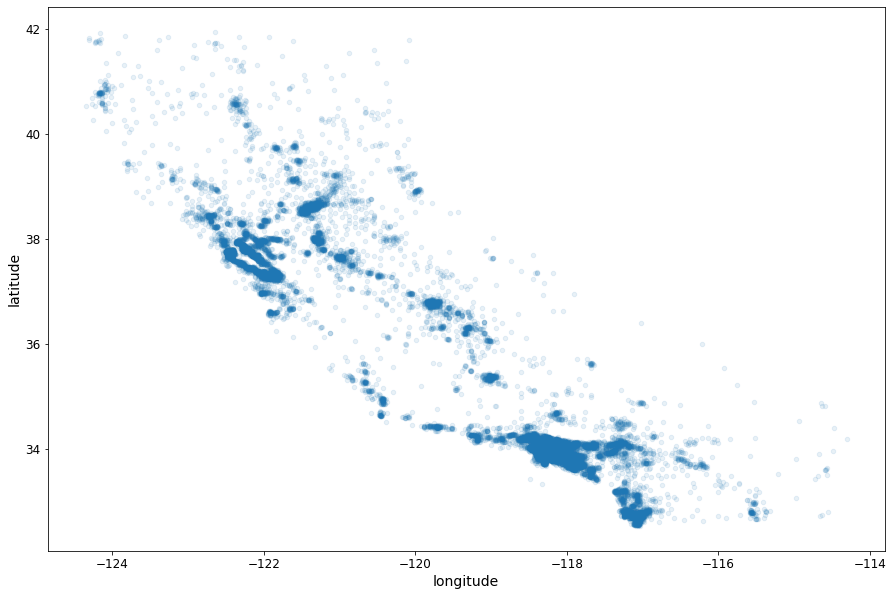

In [79]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(15, 10))

From the vis we can see easily now, where are the high-density areas. Los Angeles, San Francisco, San Diego are the places with the largest number of the data points. 



###Adding house prices and population

* circles are districts populations
* color represents prices (blue - lowest, red - highest)

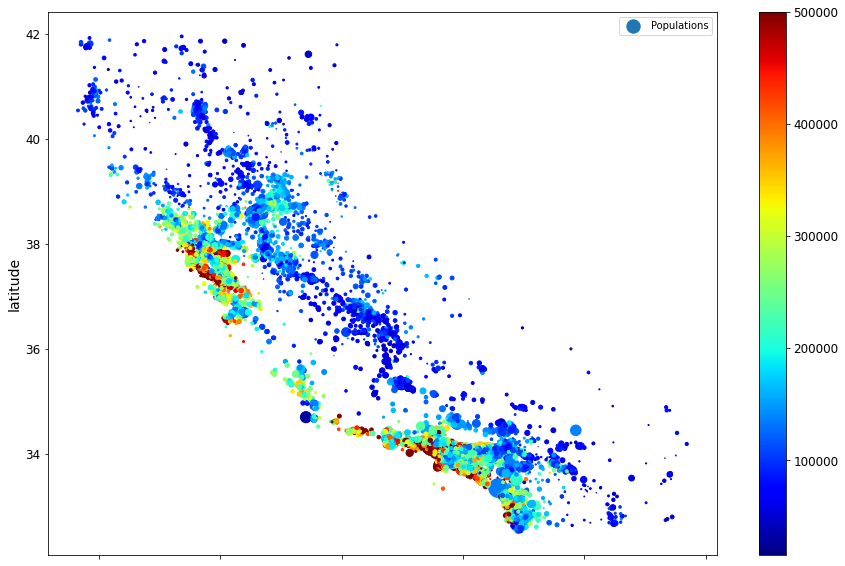

In [82]:
housing.plot(kind='scatter', x='longitude', y='latitude', 
             s=housing['population']/100, label='Populations',
             c=housing['median_house_value'], cmap=plt.get_cmap('jet'), 
             colorbar=True, figsize=(15,10))
plt.legend()

From the plot we can spot, that around the costline, and those which are the most populated, are the ones, that have the highest house prices. 

###Correlations

We'll compute Pearon's Correlations coefficient for every feature pair in the dataset. 

In [83]:
corr_matrix = housing.corr()

In [85]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64